In [56]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from pathlib import Path
import csv

data_path = Path('data')

valid_aminoacids = {
    "A", 
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V"
}

## Parse and Convert to `.csv`

In [2]:
def modify_sequence(sequence, mutation):
    """
    Modifies a sequence with a given mutation.
    
    The mutation format is `XiY` where `X` and `Y `corresponds to the original
    and the mutation aminoacid respectively, `i` corresponds to the location 
    of `X` in the original sequence (1 based indexing is expected for `i`).
    
    Example:
       sequence     mutation       mutated sequence
    'MASZGSADMAST'   'M1A'    ->    'AASZGSADMAST'
    """
    mutation = list(mutation)
    original, idx, variation = mutation[0], ''.join(mutation[1:-1]), mutation[-1]
    
    amino_is_valid = lambda x : x in valid_aminoacids
    if not (amino_is_valid(original) and amino_is_valid(variation)):
        raise ValueError(f"One of {original} or {variation} is not a valid aminoacid")
    
    return sequence[int(idx)-1:] + variation + sequence[:int(idx)]


def parse_lines(fname):
    """
    Parser for preprocessed data from: 
    ```Predicting and interpreting large scale mutagenesis data using
       analyses of protein stability and conservation```
    """
    clean_lines = []
    with open(fname) as f:
        
        lines = f.readlines()
        sequence_line_idx = 0
        column_line_idx = 0
        content_line_idx = 0
        
        for line_idx, line in enumerate(lines):
            if "sequence:" in line:
                sequence_line_idx = line_idx
                
            elif not "#" in line:
                column_line_idx = line_idx
                content_line_idx = line_idx + 1
                break
                
        sequence = lines[sequence_line_idx].split(':')[1].strip()
        columns = [col.strip() for col in lines[column_line_idx].split(' ')]
        
        clean_lines.append(columns)
        content = lines[content_line_idx:]
        
        for row_idx, row in enumerate(content):
            clean_row = []
            row = [val.strip() for val in row.split(' ') if val != '']
            mutation = row[0]
            try:
                new_seq = modify_sequence(sequence, mutation)
            except ValueError:
                continue
            
            clean_row.append(new_seq)
            for idx, val in enumerate(row[1:]):
                if val == '':
                    continue
                    
                elif val == 'NA':
                    val = np.nan
                    
                clean_row.append(val)
            
            clean_lines.append(clean_row)
    return clean_lines

In [4]:
lines = parse_lines(data_path/'preprocessed/prism_merged_999_IF-1_DMS.txt')

def write_csv(out_path, stem, lines):
    """
    Writes the given list of lines (a list of lists) to 
    a .csv with the given stem in the out directory
    """
    with open(out_path / (stem + '.csv'), "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in lines:
            writer.writerow(line)
    
def process_to_csv(to_process_path, out_dir = 'Protera'):
    """
    Processes for preprocessed data (.txt) from: 
    ```Predicting and interpreting large scale mutagenesis data using
       analyses of protein stability and conservation```
    """
    out_path = to_process_path.parent / out_dir
    out_path.mkdir(exist_ok=True)
    
    with tqdm(total = len(list((data_path / "preprocessed").iterdir())), miniters = 1, smoothing = 1) as pbar:
        for file in to_process_path.iterdir():
            if file.is_dir():
                print(f"{file} is dir")
                continue

            stem = file.stem

            lines = parse_lines(file)
            write_csv(out_path, stem, lines)
            pbar.update(1)
            pbar.refresh()

In [5]:
process_to_csv(data_path / "preprocessed")

  0%|          | 0/40 [00:00<?, ?it/s]

data/preprocessed/.ipynb_checkpoints is dir


## Concatenate to `data.csv`

In [44]:
preprocessed_path = data_path / "Protera"

dataframes = []

for file in preprocessed_path.iterdir():
    if file.is_dir():
        continue
    
    try:
        df = pd.read_csv(file)
    except Exception:
        print(file)
        continue
    dataframes.append(df)
    
data = pd.concat(dataframes).reset_index(drop = True)

In [45]:
pd.isna(data.Rosetta_ddg_score_02).sum() / len(data.Rosetta_ddg_score_02)

0.2691402069211559

In [49]:
filtered_ddg_data = data[data.Rosetta_ddg_score_02.notnull()].reset_index(drop = True)
filtered_ddg_data

,variant,score_00,log2(E1react/display)_00,Std_00,gemme_score_01,Rosetta_ddg_score_02,ss_03,rsa_03,se_00,std_00,raw_score_00,p_value_00,sd_00
0,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.650000,0.40,0.77,0.730337,0.226782,E,0.449495,NaN,NaN,NaN,NaN,NaN
1,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,1.380000,1.59,NaN,0.764747,0.782184,E,0.449495,NaN,NaN,NaN,NaN,NaN
2,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,1.060000,0.25,NaN,0.882022,1.151609,E,0.449495,NaN,NaN,NaN,NaN,NaN
3,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,NaN,NaN,NaN,0.929775,0.292759,E,0.449495,NaN,NaN,NaN,NaN,NaN
4,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,1.250000,1.03,NaN,0.689607,-0.880000,E,0.449495,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194612,HKLRKLNPPDESGPGCMSCKCVLSSMTEYKLVVVGAGGVGKSALTI...,0.066565,NaN,NaN,1.000000,0.405517,H,0.456522,NaN,NaN,NaN,NaN,NaN
194613,HKLRKLNPPDESGPGCMSCKCVLSTMTEYKLVVVGAGGVGKSALTI...,-0.005763,NaN,NaN,1.000000,0.173793,H,0.456522,NaN,NaN,NaN,NaN,NaN
194614,HKLRKLNPPDESGPGCMSCKCVLSVMTEYKLVVVGAGGVGKSALTI...,-0.136136,NaN,NaN,1.000000,2.447356,H,0.456522,NaN,NaN,NaN,NaN,NaN
194615,HKLRKLNPPDESGPGCMSCKCVLSWMTEYKLVVVGAGGVGKSALTI...,-0.152536,NaN,NaN,1.000000,1.032299,H,0.456522,NaN,NaN,NaN,NaN,NaN


In [64]:
(filtered_ddg_data.variant.apply(len) > 1024).sum() / len(filtered_ddg_data), (filtered_ddg_data.variant.apply(len) > 1024).sum(), len(filtered_ddg_data)

(0.11139314653909987, 21679, 194617)

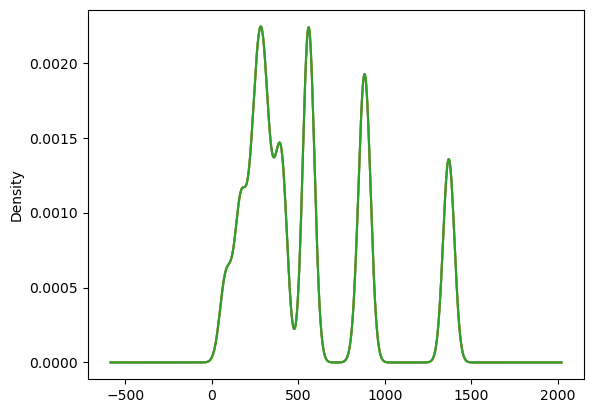

In [57]:
filtered_ddg_data.variant.apply(len).plot.density()
plt.show()

In [51]:
filtered_ddg_data.to_csv(data_path / "Protera" / "data.csv", index = False)